# Code adapted from:

https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb

In [1]:
#Uncomment to install ydata-synthetic lib
#!pip3 install ydata-synthetic


[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from the [Kaggle M5 Forecasting Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/data) containing Walmart store sales data. I aggregated the unit sales data across all products in each time period at the store level, resulting in:
    - **10 time series of total unit sales, one for each store** 
    - **1913 events** 

In [3]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.


# Specific to TimeGANs

The article covering the code used 24 data point for rolling window (seq_len) following the original paper recommendations

In [4]:
# The article covering the code used 24 data point for rolling window (seq_len) following the original paper recommendations
seq_len=24
# n_seq represents the number of columns, which I updated to 10
n_seq = 10
# Every other parameter was left as is
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [5]:
store_data = processed_stock(path='/Users/iustintoader/Desktop/Research/CollaborativeForecasting/Coding/store_gan_generation/trans_agg_by_store.csv', seq_len=seq_len)
print(len(store_data),store_data[0].shape)

1889 (24, 10)


Code to replicate the rolling-window creation phase of processed_stock

In [7]:
"""temp_data=[]
for i in range (1, len(store_data)-24):
  _x=store_data[i:i+24]
  temp_data.append(_x)

print(temp_data[len(temp_data)-1])"""

[array([[0.54763961, 0.44923547, 0.62957807, 0.68561173, 0.51233141,
        0.57147063, 0.40717143, 0.33222254, 0.47529292, 0.51063479],
       [0.55066206, 0.4469419 , 0.67659028, 0.62339216, 0.58786127,
        0.61636979, 0.48155282, 0.33801797, 0.53871625, 0.53091509],
       [0.6646517 , 0.54571865, 0.70593275, 0.67873168, 0.61136802,
        0.64286766, 0.4717736 , 0.40843234, 0.57832399, 0.58516076],
       [0.82843984, 0.71697248, 0.87556222, 0.84116063, 0.82755299,
        0.85602826, 0.63935398, 0.49275572, 0.5565461 , 0.65424567],
       [0.96473805, 0.66299694, 1.        , 0.96440323, 0.81695568,
        0.91417636, 0.65624537, 0.52042886, 0.66390728, 0.73404782],
       [0.66968912, 0.46498471, 0.79481688, 0.74723302, 0.61965318,
        0.6505226 , 0.50955697, 0.36902347, 0.60290372, 0.62539159],
       [0.60002879, 0.42844037, 0.74876847, 0.73107987, 0.54412331,
        0.49256588, 0.41813602, 0.34424804, 0.52050433, 0.46133553],
       [0.53180771, 0.42599388, 0.718248

Overlapping rolling-window algorithm leaves out the final entry in the original timeseries 
(because of division by seq_len of 24)

## Training the TimeGAN synthetizer

In [12]:
if path.exists('/Users/iustintoader/Desktop/Research/CollaborativeForecasting/Coding/store_gan_generation/synthesizer_store.pkl'):
    print("here")
    synth = TimeGAN.load('/Users/iustintoader/Desktop/Research/CollaborativeForecasting/Coding/store_gan_generation/synthesizer_store.pkl')
else:
    print("not here")
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(store_data, train_steps=50000)
    synth.save('synthesizer_store.pkl')

here


### The generated synthetic store sales data

In [13]:
synth_data = synth.sample(len(store_data))
print(synth_data.shape)

Synthetic data generation: 100%|████████████████| 15/15 [00:02<00:00,  5.84it/s]

(1920, 24, 10)


Reshaping the data

In [14]:
cols = ["CA_1","CA_2","CA_3","CA_4","TX_1","TX_2","TX_3","WI_1","WI_2","WI_3"]

Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]

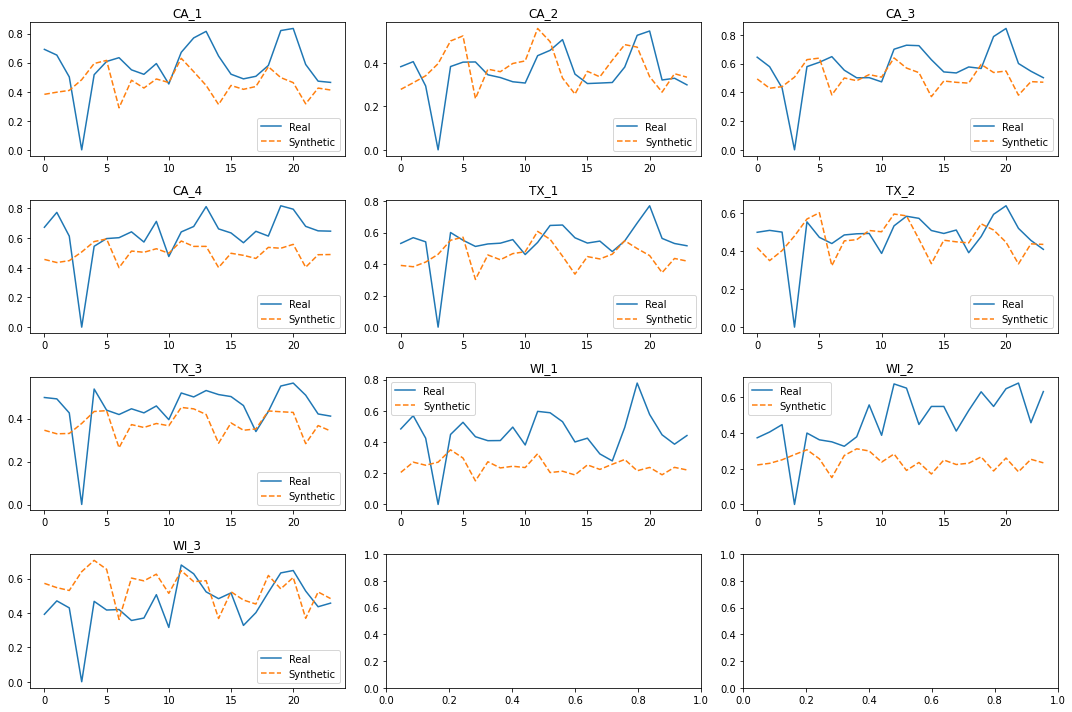

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(store_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': store_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(store_data))[:sample_size]

real_sample = np.asarray(store_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

For the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.

In [17]:
synth_data_reduced = real_sample.reshape(-1, seq_len)
store_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

The fit of the methods must be done only using the real sequential data

In [18]:
pca.fit(store_data_reduced)

pca_real = pd.DataFrame(pca.transform(store_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((store_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


The scatter plots for PCA and TSNE methods

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

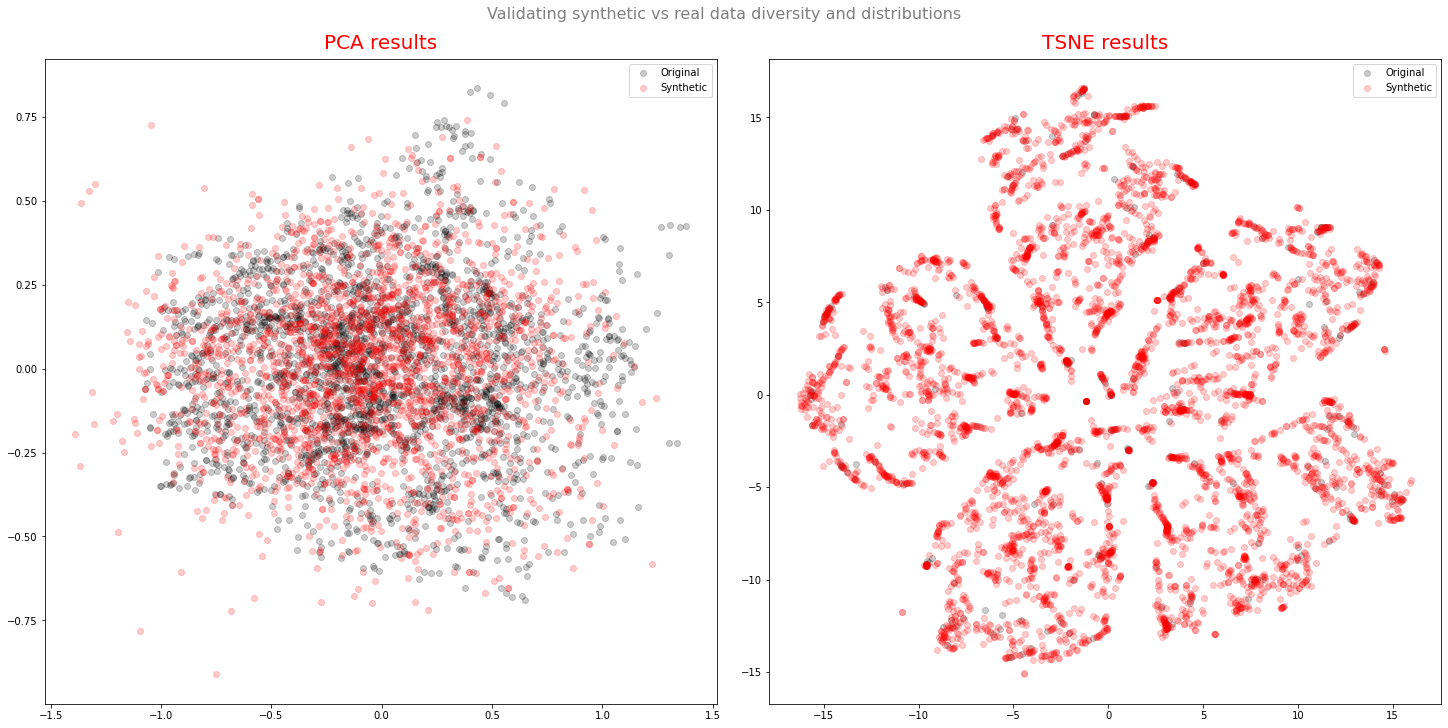

In [22]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [23]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

First implement a simple RNN model for prediction

In [24]:
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    #units for below function represent the number of columns, which I changed to 10
    model.add(Dense(units=10,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

Prepare the dataset for the regression model

In [25]:
store_data=np.asarray(store_data)
synth_data = synth_data[:len(store_data)]
n_events = len(store_data)

Split data on train and test

In [26]:
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

Define the X for synthetic and real data

In [27]:
X_store_train = store_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_store_test = store_data[test_idx, :seq_len-1, :]
y_store_test = store_data[test_idx, -1, :]

Define the y for synthetic and real datasets

In [28]:
y_store_train = store_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

In [29]:
print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_store_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_store_train.shape))

print('Real X test: {}'.format(X_store_test.shape))
print('Real y test: {}'.format(y_store_test.shape))

Synthetic X train: (1416, 23, 10)
Real X train: (1416, 23, 10)
Synthetic y train: (1416, 10)
Real y train: (1416, 10)
Real X test: (473, 23, 10)
Real y test: (473, 10)


Training the model with the real train data

In [30]:
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_store_train,
                          y=y_store_train,
                          validation_data=(X_store_test, y_store_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
12/12 [==============================] - 2s 35ms/step - loss: 0.1442 - val_loss: 0.1322
Epoch 2/200
12/12 [==============================] - 0s 11ms/step - loss: 0.1281 - val_loss: 0.1213
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 0.1168 - val_loss: 0.1141
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.1116 - val_loss: 0.1088
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 0.1087 - val_loss: 0.1051
Epoch 6/200
12/12 [==============================] - 0s 11ms/step - loss: 0.1027 - val_loss: 0.1027
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0997 - val_loss: 0.1012
Epoch 8/200
12/12 [==============================] - 0s 8ms/step - loss: 0.1008 - val_loss: 0.1005
Epoch 9/200
12/12 [==============================] - 0s 9ms/step - loss: 0.1002 - val_loss: 0.1002
Epoch 10/200
12/12 [==============================] - 0s 11ms/step - loss: 0.0985 - val_loss: 0.0999
E

Training the model with the synthetic data

In [31]:
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_store_test, y_store_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
12/12 [==============================] - 2s 36ms/step - loss: 0.1454 - val_loss: 0.1250
Epoch 2/200
12/12 [==============================] - 0s 15ms/step - loss: 0.1293 - val_loss: 0.1145
Epoch 3/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1169 - val_loss: 0.1101
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 0.1081 - val_loss: 0.1078
Epoch 5/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1092 - val_loss: 0.1060
Epoch 6/200
12/12 [==============================] - 0s 14ms/step - loss: 0.1025 - val_loss: 0.1050
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 0.1020 - val_loss: 0.1048
Epoch 8/200
12/12 [==============================] - 0s 11ms/step - loss: 0.1011 - val_loss: 0.1047
Epoch 9/200
12/12 [==============================] - 0s 11ms/step - loss: 0.0992 - val_loss: 0.1045
Epoch 10/200
12/12 [==============================] - 0s 13ms/step - loss: 0.0997 - val_loss: 0.1043

Summarize the metrics here as a pandas dataframe

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_store_test)
synth_predictions = ts_synth.predict(X_store_test)

metrics_dict = {'r2': [r2_score(y_store_test, real_predictions),
                       r2_score(y_store_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_store_test, real_predictions),
                        mean_absolute_error(y_store_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_store_test, real_predictions),
                         mean_squared_log_error(y_store_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,0.479819,0.070792,0.003807
Synthetic,0.014593,0.104409,0.007666
